# Frontloading

# Phase 2 vs. Phase 2

Following protocol from Gurr et al., “Acclimatory Gene Expression of Primed Clams Enhances Robustness to Elevated pCO2.” - who was originally inspired by Barshis et al., “Genomic Basis for Coral Resilience to Climate Change.”

[Gurr GitHub script](https://github.com/SamGurr/Pgenerosa_OA_TagSeq/blob/main/TagSeq/Analysis/Scripts/DE_frontloading.R)

## 0. load libraries

In [46]:
library(tidyverse)
library(reshape2)


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




## 1. read CSVs

In [24]:
# get list of files
files <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs',
    pattern = '\\.csv$',
    full.names = TRUE
    )

# read each csv
deg_list <- lapply(files, read.csv)

# name list elements after the files
names(deg_list) <- gsub('DEG_','',tools::file_path_sans_ext(basename(files)))

# check things worked
names(deg_list)
head(deg_list$bb_cc)

[1] "bb_cc" "bc_bb" "bc_cb" "bc_cc" "bc_hc" "bc_wc" "bh_hh" "bw_ww" "cb_bb"
[10] "cb_bc" "cb_cc" "cb_ch" "cb_cw" "ch_cc" "ch_hc" "cw_cc" "cw_ch" "cw_wc"
[19] "hb_bb" "hb_bh" "hb_cb" "hc_cc" "hc_ch" "hc_hh" "hh_cc" "hh_ch" "wb_bb"
[28] "wb_bw" "wb_cb" "wc_cc" "wc_cw" "wc_hc" "wc_ww" "wh_hw" "ww_cc" "ww_cw"

,X,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48,pair,DEG_group
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,726,LOC111134671,613.020976,1.705185,1.8602511,-3.890429,1.000673e-04,0.023871608,0.123867402,1623.040284,⋯,340.657679,46.877027,18.29407,181.5113,1580.693519,112.349708,34.203014,363.075510,CC vs. BB,BB
2,1086,LOC111120923,146.529937,-5.243692,4.1847160,3.947822,7.886530e-05,0.020048777,0.059178297,10.266500,⋯,182.671509,8.976452,0.00000,398.6953,184.147364,39.652838,5.344221,9.499069,CC vs. BB,CC
3,1148,LOC111136853,86.689266,-1.963764,2.6599338,3.713204,2.046516e-04,0.040461455,0.170868504,2.799954,⋯,3.702801,15.958137,0.00000,0.0000,6.862635,17.623484,2.137688,21.109041,CC vs. BB,CC
4,1221,LOC111120760,103.711700,2.616076,0.9408944,-4.651563,3.294284e-06,0.001389420,0.006801697,62.532317,⋯,30.856674,90.761903,197.57595,102.8214,81.207844,44.058709,40.616079,85.491617,CC vs. BB,BB
5,3058,LOC111125595,123.169520,17.307451,9.1757285,-4.195594,2.721571e-05,0.008903943,0.022714995,490.925353,⋯,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,CC vs. BB,BB
6,3219,LOC111114504,6.398528,7.268181,7.7009243,-3.710223,2.070769e-04,0.040461455,0.119596502,0.000000,⋯,0.000000,0.000000,0.00000,0.0000,19.444132,2.202935,0.000000,0.000000,CC vs. BB,BB


## 2. Frontloading!

### Step 1: pull up-regulated genes in oysters first exposed to control conditions
The first step in identifying frontloading is to pull genes that were up-regulated in oysters that were first exposed to control conditions, and then were exposed to stress (CW, CH, CB vs. CC)

(also going to do these steps simultaneously for warm, hypoxia, and both, but just focusing on frontloading within these stressors - not thinking about interactions of stressors yet)

In [33]:
# warm up-regulated
cw_cc.UP <- deg_list$cw_cc %>% filter(log2FoldChange > 0) %>% select(!X)
dim(cw_cc.UP)

# hypoxia up-regulated
ch_cc.UP <- deg_list$ch_cc %>% filter(log2FoldChange > 0) %>% select(!X)
dim(ch_cc.UP)

# both up-regulated
cb_cc.UP <- deg_list$cb_cc %>% filter(log2FoldChange > 0) %>% select(!X)
dim(cb_cc.UP)

[1]  71 106

[1]  72 106

[1]  80 106

### Step 2: calculate mean expression for each treatment combo

In [38]:
metaData <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv') %>%
mutate(All_treatment = factor(paste0(Phase1_treatment, '_', Phase2_treatment))) %>% # add column for p1 and p2 treatment combined, make treatment groups a factor
filter(!is.na(Phase2_treatment)) %>% # remove phase 1 samples
select(Sample, All_treatment) # grab only the needed columns 

dim(metaData)
head(metaData)

[1] 96  2

,Sample,All_treatment
,<chr>,<fct>
1,B1_B1_O01,both_both
2,B1_W5_O50,both_warm
3,B2_B5_O51,both_both
4,B2_C4_O40,both_control
5,B3_B4_O41,both_both
6,B3_C3_O30,both_control


In [59]:
# CW vs. CC

cw_ccUP_melted <- cw_cc.UP %>% 
dplyr::select(
    Gene,
    where(is.numeric),
    -c(baseMean, log2FoldChange, lfcSE, stat, pvalue, padj, svalue)
  ) %>% 
  reshape2::melt(id.vars = "Gene") %>% 
  dplyr::rename(Sample = variable)

cw_ccUP_TreatMerge <- merge(cw_ccUP_melted, metaData, by = 'Sample') %>% 
                        dplyr::group_by(Gene, All_treatment) %>% 
                        dplyr::select(!'Sample') %>% 
                        dplyr::summarise(meanExp = mean(value))

cw_ccUP_READY <- dcast(cw_ccUP_TreatMerge, Gene ~ All_treatment)
head(cw_ccUP_READY)

`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
Using meanExp as value column: use value.var to override.



,Gene,both_both,both_control,both_hypoxic,both_warm,control_both,control_control,control_hypoxic,control_warm,hypoxic_both,hypoxic_control,hypoxic_hypoxic,hypoxic_warm,warm_both,warm_control,warm_hypoxic,warm_warm
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,LOC111099630,30.9970731,209.8074965,0.000000,9.0410686,0.5384872,0.000000,13.8125540,1.616827,1.5938536,0.3517412,105.0610495,0.000000,0.0000000,0.7917514,0.0000000,1.7590868
2,LOC111099767,11.7733312,0.9515838,5.831273,0.3146036,0.3181367,2.478063,5.8810513,116.777773,1.3534991,0.5620585,3.5000770,2.302966,4.6388879,7.8178809,10.0510276,7.3066780
3,LOC111099906,1.2491370,1.2197805,41.253194,0.0000000,0.1611699,0.000000,2.0076820,1.532922,3.5556738,3.4511742,0.1495427,1.510533,5.6588652,15.1819369,0.3671559,5.1914024
4,LOC111099988,0.0000000,87.7967535,0.000000,0.0000000,148.9589347,0.000000,19.0274892,39.927130,40.7273145,0.0000000,11.3873180,16.065632,15.9936595,0.0000000,0.0000000,205.7157310
5,LOC111100493,15.9671308,20.0155401,1.545915,1.9752173,14.7580009,0.000000,0.7248567,31.817246,46.5723822,9.6728822,54.6591262,2.209192,94.2700336,0.0000000,5.0783340,32.8103059
6,LOC111100764,0.1915077,0.1086786,1.908892,0.1639098,0.5040703,0.000000,0.6760772,18.428817,0.3187707,0.0000000,0.6523815,1.212819,0.3662279,0.0000000,0.3324612,0.1137982


In [60]:
# CH vs. CC

ch_ccUP_melted <- ch_cc.UP %>% 
dplyr::select(
    Gene,
    where(is.numeric),
    -c(baseMean, log2FoldChange, lfcSE, stat, pvalue, padj, svalue)
  ) %>% 
  reshape2::melt(id.vars = "Gene") %>% 
  dplyr::rename(Sample = variable)

ch_ccUP_TreatMerge <- merge(ch_ccUP_melted, metaData, by = 'Sample') %>% 
                        dplyr::group_by(Gene, All_treatment) %>% 
                        dplyr::select(!'Sample') %>% 
                        dplyr::summarise(meanExp = mean(value))

ch_ccUP_READY <- dcast(ch_ccUP_TreatMerge, Gene ~ All_treatment)
head(ch_ccUP_READY)

`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
Using meanExp as value column: use value.var to override.



,Gene,both_both,both_control,both_hypoxic,both_warm,control_both,control_control,control_hypoxic,control_warm,hypoxic_both,hypoxic_control,hypoxic_hypoxic,hypoxic_warm,warm_both,warm_control,warm_hypoxic,warm_warm
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,LOC111099607,47.5649750,14.0370347,6.375494,12.4571455,1.6702917,0,0.4869427,0.000000,0.7708090,0.1531328,23.0189447,29.633752,9.7804177,1.2342670,9.9287729,40.3001536
2,LOC111099630,30.9970731,209.8074965,0.000000,9.0410686,0.5384872,0,13.8125540,1.616827,1.5938536,0.3517412,105.0610495,0.000000,0.0000000,0.7917514,0.0000000,1.7590868
3,LOC111099906,1.2491370,1.2197805,41.253194,0.0000000,0.1611699,0,2.0076820,1.532922,3.5556738,3.4511742,0.1495427,1.510533,5.6588652,15.1819369,0.3671559,5.1914024
4,LOC111099988,0.0000000,87.7967535,0.000000,0.0000000,148.9589347,0,19.0274892,39.927130,40.7273145,0.0000000,11.3873180,16.065632,15.9936595,0.0000000,0.0000000,205.7157310
5,LOC111100493,15.9671308,20.0155401,1.545915,1.9752173,14.7580009,0,0.7248567,31.817246,46.5723822,9.6728822,54.6591262,2.209192,94.2700336,0.0000000,5.0783340,32.8103059
6,LOC111100764,0.1915077,0.1086786,1.908892,0.1639098,0.5040703,0,0.6760772,18.428817,0.3187707,0.0000000,0.6523815,1.212819,0.3662279,0.0000000,0.3324612,0.1137982


In [61]:
# CB vs. CC

cb_ccUP_melted <- cb_cc.UP %>% 
dplyr::select(
    Gene,
    where(is.numeric),
    -c(baseMean, log2FoldChange, lfcSE, stat, pvalue, padj, svalue)
  ) %>% 
  reshape2::melt(id.vars = "Gene") %>% 
  dplyr::rename(Sample = variable)

cb_ccUP_TreatMerge <- merge(cb_ccUP_melted, metaData, by = 'Sample') %>% 
                        dplyr::group_by(Gene, All_treatment) %>% 
                        dplyr::select(!'Sample') %>% 
                        dplyr::summarise(meanExp = mean(value))

cb_ccUP_READY <- dcast(cb_ccUP_TreatMerge, Gene ~ All_treatment)
head(cb_ccUP_READY)

`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
Using meanExp as value column: use value.var to override.



,Gene,both_both,both_control,both_hypoxic,both_warm,control_both,control_control,control_hypoxic,control_warm,hypoxic_both,hypoxic_control,hypoxic_hypoxic,hypoxic_warm,warm_both,warm_control,warm_hypoxic,warm_warm
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,LOC111099607,47.564975,14.037035,6.375494,12.457146,1.6702917,0.000000,0.4869427,0.000000,0.770809,0.1531328,23.0189447,29.633752,9.780418,1.2342670,9.9287729,40.300154
2,LOC111099630,30.997073,209.807496,0.000000,9.041069,0.5384872,0.000000,13.8125540,1.616827,1.593854,0.3517412,105.0610495,0.000000,0.000000,0.7917514,0.0000000,1.759087
3,LOC111099705,4.754348,7.471397,134.584580,17.939202,83.0015834,5.030481,9.5615934,10.486712,93.075410,3.5362736,7.1786282,33.225436,10.392794,6.8033692,9.3142595,4.859711
4,LOC111099906,1.249137,1.219780,41.253194,0.000000,0.1611699,0.000000,2.0076820,1.532922,3.555674,3.4511742,0.1495427,1.510533,5.658865,15.1819369,0.3671559,5.191402
5,LOC111099988,0.000000,87.796753,0.000000,0.000000,148.9589347,0.000000,19.0274892,39.927130,40.727314,0.0000000,11.3873180,16.065632,15.993659,0.0000000,0.0000000,205.715731
6,LOC111100493,15.967131,20.015540,1.545915,1.975217,14.7580009,0.000000,0.7248567,31.817246,46.572382,9.6728822,54.6591262,2.209192,94.270034,0.0000000,5.0783340,32.810306


### Step 3: calculate x and y axis of frontloading figure
input dfs:
- cw_ccUP_READY
- ch_ccUP_READY
- cb_ccUP_READY

#### X axis
this is the relative fold ratio of the stress-control to the control-control as the following: 

[ (HH/HC) / (CH/CC) ]

values <1 indicate genes that are lower response to stress than phase 1 control oysters (opposite for values >1)

In [62]:
## WARM ##
w.xall_1 <- ( (cw_ccUP_READY$warm_warm / cw_ccUP_READY$warm_control) / (cw_ccUP_READY$control_warm / cw_ccUP_READY$control_control) ) # call WC as control for WW ratio
w.xall_2 <- ( (cw_ccUP_READY$warm_warm / cw_ccUP_READY$control_control) / (cw_ccUP_READY$control_warm / cw_ccUP_READY$control_control) ) # call CC as control for WW ratio
w.xall_3 <- (cw_ccUP_READY$warm_warm / cw_ccUP_READY$control_warm) # call CC as control for WW ratio

cw_ccUP_READY$xall_1 <- w.xall_1
cw_ccUP_READY$xall_2 <- w.xall_2
cw_ccUP_READY$xall_3 <- w.xall_3

In [65]:
## HYPOXIA ##
h.xall_1 <- ( (ch_ccUP_READY$hypoxic_hypoxic / ch_ccUP_READY$hypoxic_control) / (ch_ccUP_READY$control_hypoxic / ch_ccUP_READY$control_control) ) # call HC as control for HH ratio
h.xall_2 <- ( (ch_ccUP_READY$hypoxic_hypoxic / ch_ccUP_READY$control_control) / (ch_ccUP_READY$control_hypoxic / ch_ccUP_READY$control_control) ) # call CC as control for HH ratio
h.xall_3 <- (ch_ccUP_READY$hypoxic_hypoxic / ch_ccUP_READY$control_hypoxic) # call CC as control for HH ratio

ch_ccUP_READY$xall_1 <- h.xall_1
ch_ccUP_READY$xall_2 <- h.xall_2
ch_ccUP_READY$xall_3 <- h.xall_3

In [66]:
## BOTH ##
b.xall_1 <- ( (cb_ccUP_READY$both_both / cb_ccUP_READY$both_control) / (cb_ccUP_READY$control_both / cb_ccUP_READY$control_control) ) # call BC as control for BB ratio
b.xall_2 <- ( (cb_ccUP_READY$both_both / cb_ccUP_READY$control_control) / (cb_ccUP_READY$control_both / cb_ccUP_READY$control_control) ) # call CC as control for BB ratio
b.xall_3 <- (cb_ccUP_READY$both_both / cb_ccUP_READY$control_both) # call CC as control for BB ratio

cb_ccUP_READY$xall_1 <- b.xall_1
cb_ccUP_READY$xall_2 <- b.xall_2
cb_ccUP_READY$xall_3 <- b.xall_3

#### Y axis
this is stress-control over control-control

( HC / CC)


In [67]:
## WARM ##
w.yall <- (cw_ccUP_READY$warm_control / cw_ccUP_READY$control_control)
cw_ccUP_READY$yall <- w.yall

## HYPOXIA ##
h.yall <- (ch_ccUP_READY$hypoxic_control / ch_ccUP_READY$control_control)
ch_ccUP_READY$yall <- h.yall

## BOTH ##
b.yall <- (cb_ccUP_READY$both_control / cb_ccUP_READY$control_control)
cb_ccUP_READY$yall <- b.yall

### Step 4: plot it!

Warning message:
“Removed 45 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”


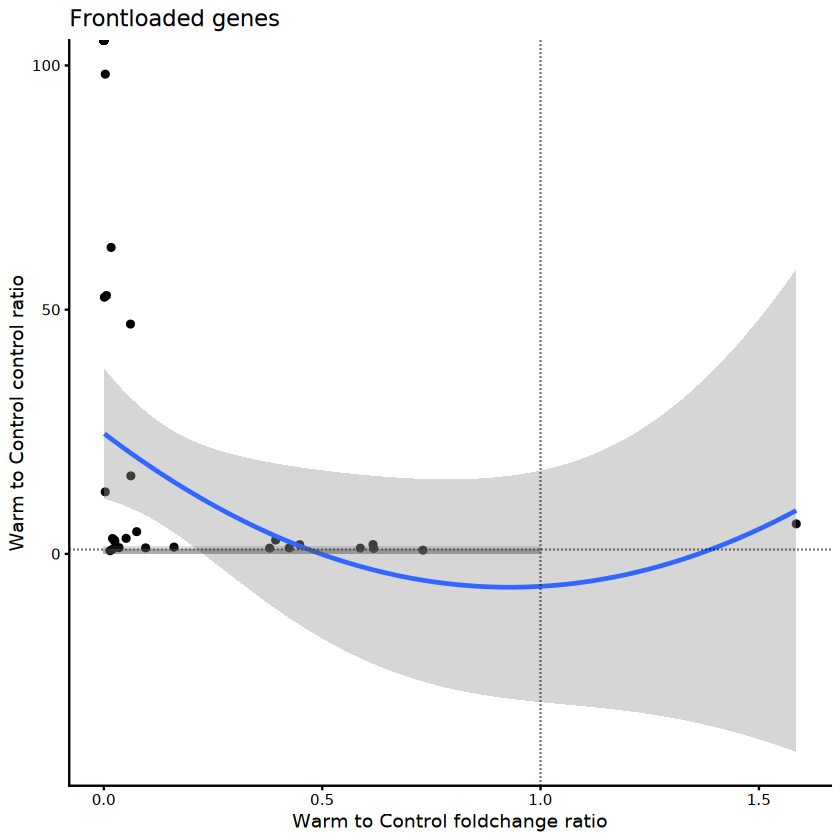

In [70]:
W <- cw_ccUP_READY %>% #dplyr::filter(yall < 6) %>% 
        ggplot(aes(x=xall_1, y=yall)) +
        geom_point() +
        theme_classic() + 
        stat_smooth(method = "lm", 
                    formula = y ~ x + poly(x, 2) - 1) +
        geom_vline(xintercept=1, linetype="dotted") + 
        geom_hline(yintercept=1, linetype="dotted") + 
        labs(y= "Warm to Control control ratio", 
             x = "Warm to Control foldchange ratio",
             title = "Frontloaded genes") + 
        expand_limits(x = 0, y = 0) + 
  annotate("rect", xmin = 0, xmax = 1, ymin = 1, ymax = 1.5,
           alpha = .2) + 
  annotate("rect", xmin = 0, xmax = 1, ymin = 0, ymax = 1,
           alpha = .5)
W

Warning message:
“Removed 51 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 16 rows containing missing values or values outside the scale range
(`geom_point()`).”


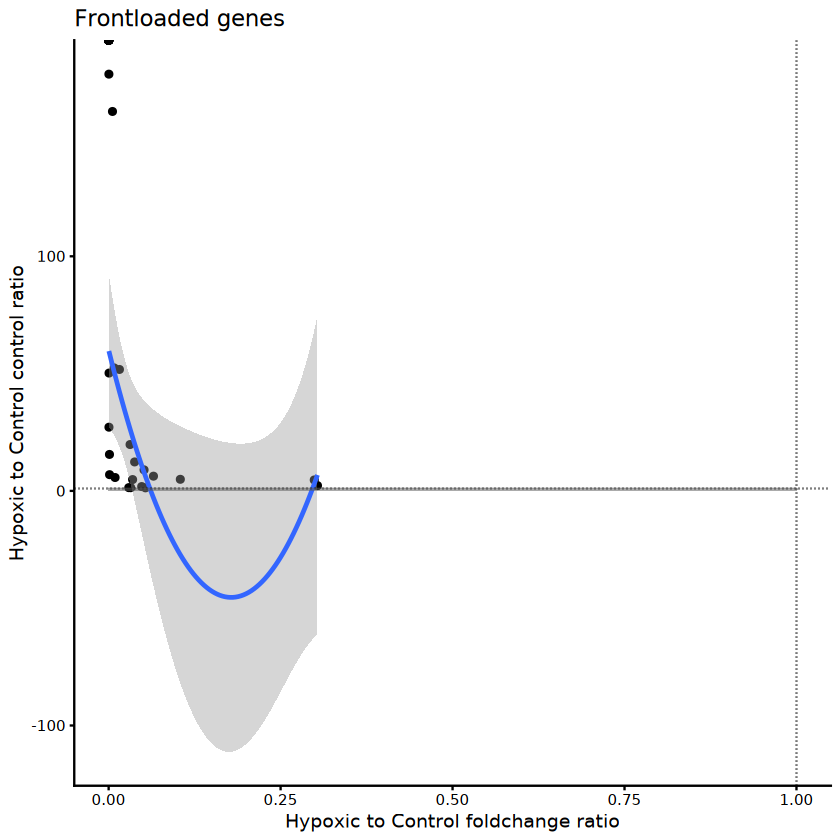

In [69]:
H <- ch_ccUP_READY %>% #dplyr::filter(yall < 6) %>% 
        ggplot(aes(x=xall_1, y=yall)) +
        geom_point() +
        theme_classic() + 
        stat_smooth(method = "lm", 
                    formula = y ~ x + poly(x, 2) - 1) +
        geom_vline(xintercept=1, linetype="dotted") + 
        geom_hline(yintercept=1, linetype="dotted") + 
        labs(y= "Hypoxic to Control control ratio", 
             x = "Hypoxic to Control foldchange ratio",
             title = "Frontloaded genes") + 
        expand_limits(x = 0, y = 0) + 
  annotate("rect", xmin = 0, xmax = 1, ymin = 1, ymax = 1.5,
           alpha = .2) + 
  annotate("rect", xmin = 0, xmax = 1, ymin = 0, ymax = 1,
           alpha = .5)
H

Warning message:
“Removed 56 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_point()`).”


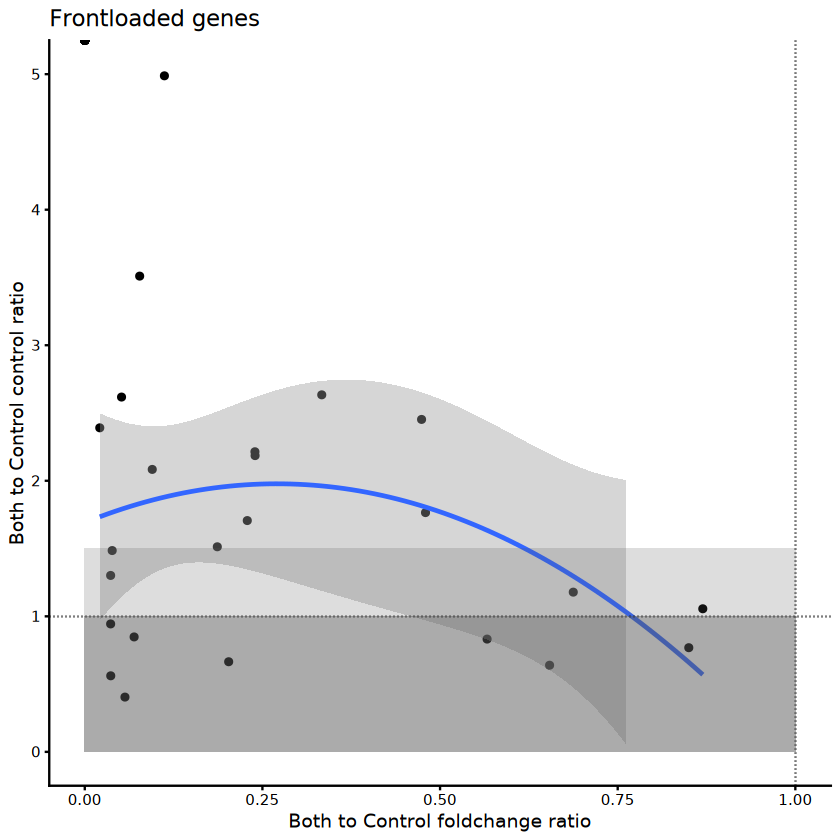

In [73]:
B <- cb_ccUP_READY %>% #dplyr::filter(yall < 6) %>% 
        ggplot(aes(x=xall_1, y=yall)) +
        geom_point() +
        theme_classic() + 
        stat_smooth(method = "lm", 
                    formula = y ~ x + poly(x, 2) - 1) +
        geom_vline(xintercept=1, linetype="dotted") + 
        geom_hline(yintercept=1, linetype="dotted") + 
        labs(y= "Both to Control control ratio", 
             x = "Both to Control foldchange ratio",
             title = "Frontloaded genes") + 
        expand_limits(x = 0, y = 0) + 
  annotate("rect", xmin = 0, xmax = 1, ymin = 1, ymax = 1.5,
           alpha = .2) + 
  annotate("rect", xmin = 0, xmax = 1, ymin = 0, ymax = 1,
           alpha = .5) +
ylim(0,5)
B